<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMPORT-PACKAGES" data-toc-modified-id="IMPORT-PACKAGES-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMPORT PACKAGES</a></span></li><li><span><a href="#LOAD-DATA" data-toc-modified-id="LOAD-DATA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LOAD DATA</a></span></li><li><span><a href="#0.-FFI-Distribution" data-toc-modified-id="0.-FFI-Distribution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>0. FFI Distribution</a></span></li><li><span><a href="#Cross-Validation-adn-1v1-class." data-toc-modified-id="Cross-Validation-adn-1v1-class.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cross-Validation adn 1v1 class.</a></span></li><li><span><a href="#1.-2X2-K-fold-Matrix" data-toc-modified-id="1.-2X2-K-fold-Matrix-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>1. 2X2 K-fold Matrix</a></span></li><li><span><a href="#2.-TSNE" data-toc-modified-id="2.-TSNE-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>2. TSNE</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#UMAP" data-toc-modified-id="UMAP-6.0.1"><span class="toc-item-num">6.0.1&nbsp;&nbsp;</span>UMAP</a></span></li><li><span><a href="#Obtain-t/p-values" data-toc-modified-id="Obtain-t/p-values-6.0.2"><span class="toc-item-num">6.0.2&nbsp;&nbsp;</span>Obtain t/p-values</a></span></li></ul></li></ul></li><li><span><a href="#3.-Training-Positives-vs-Test-Performance" data-toc-modified-id="3.-Training-Positives-vs-Test-Performance-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>3. Training Positives vs Test Performance</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Single-Exp" data-toc-modified-id="Single-Exp-7.0.1"><span class="toc-item-num">7.0.1&nbsp;&nbsp;</span>Single Exp</a></span></li><li><span><a href="#All-Exp" data-toc-modified-id="All-Exp-7.0.2"><span class="toc-item-num">7.0.2&nbsp;&nbsp;</span>All Exp</a></span></li></ul></li></ul></li></ul></div>

# IMPORT PACKAGES

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
# Standard Libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

# from fastdtw import fastdtw
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm
from collections import Counter

In [3]:
# Custom Libraries 
import python_libraries.fitting_func as fitfunc
import python_libraries.peak_finder as peakfunc
import python_libraries.plotting_func as plotfunc
import python_libraries.utilities as utils
import python_libraries.outlier_detection as outfunc
import python_libraries.classifiers_v2 as mlfunc

In [4]:
# Machine Learning Libraries
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

from scipy.spatial.distance import euclidean

from numpy.random import seed

seed(10)

In [5]:
import matplotlib as mpl
from cycler import cycler
from matplotlib.colors import to_hex
mpl.rcParams['axes.prop_cycle'] = cycler(color=[to_hex(i) for i in
                                                [(0,0.45,0.70),
                                                (0.9, 0.6, 0.0),
                                                (0.0, 0.60, 0.50),
                                                (0.8, 0.4, 0),
                                                (0.35, 0.7, 0.9),
                                                (0.8, 0.6, 0.7),
                                                (0,0,0),
                                                (0.5, 0.5, 0.5),
                                                (0.286, 0, 0.573)]])

# LOAD DATA

In [6]:
df_dAC_pos = pd.read_csv('dataframe_saved/01_df_AC_filt_bs.csv', header=0, index_col=0, low_memory=False)
df_dMC_pos = pd.read_csv('dataframe_saved/01_df_MC_filt_bs.csv', header=0, index_col=0, low_memory=False)
df_master = pd.read_csv('dataframe_saved/01_df_master_filt.csv', header=0, index_col=0, low_memory=False)

NMETA=6

# 0. FFI Distribution 

In [7]:
X_AC = df_master.iloc[:, NMETA+1:].values
X_MC = df_master.loc[:, ['MeltPeaks']].values    
X_FFI = df_master.iloc[:,[-1]].values
   
encoder = LabelEncoder()
encoder.fit(df_master['Target'])
ytrue = encoder.transform(df_master['Target'])

X_MC.shape, X_AC.shape, X_FFI.shape, ytrue.shape

((54186, 1), (54186, 35), (54186, 1), (54186,))

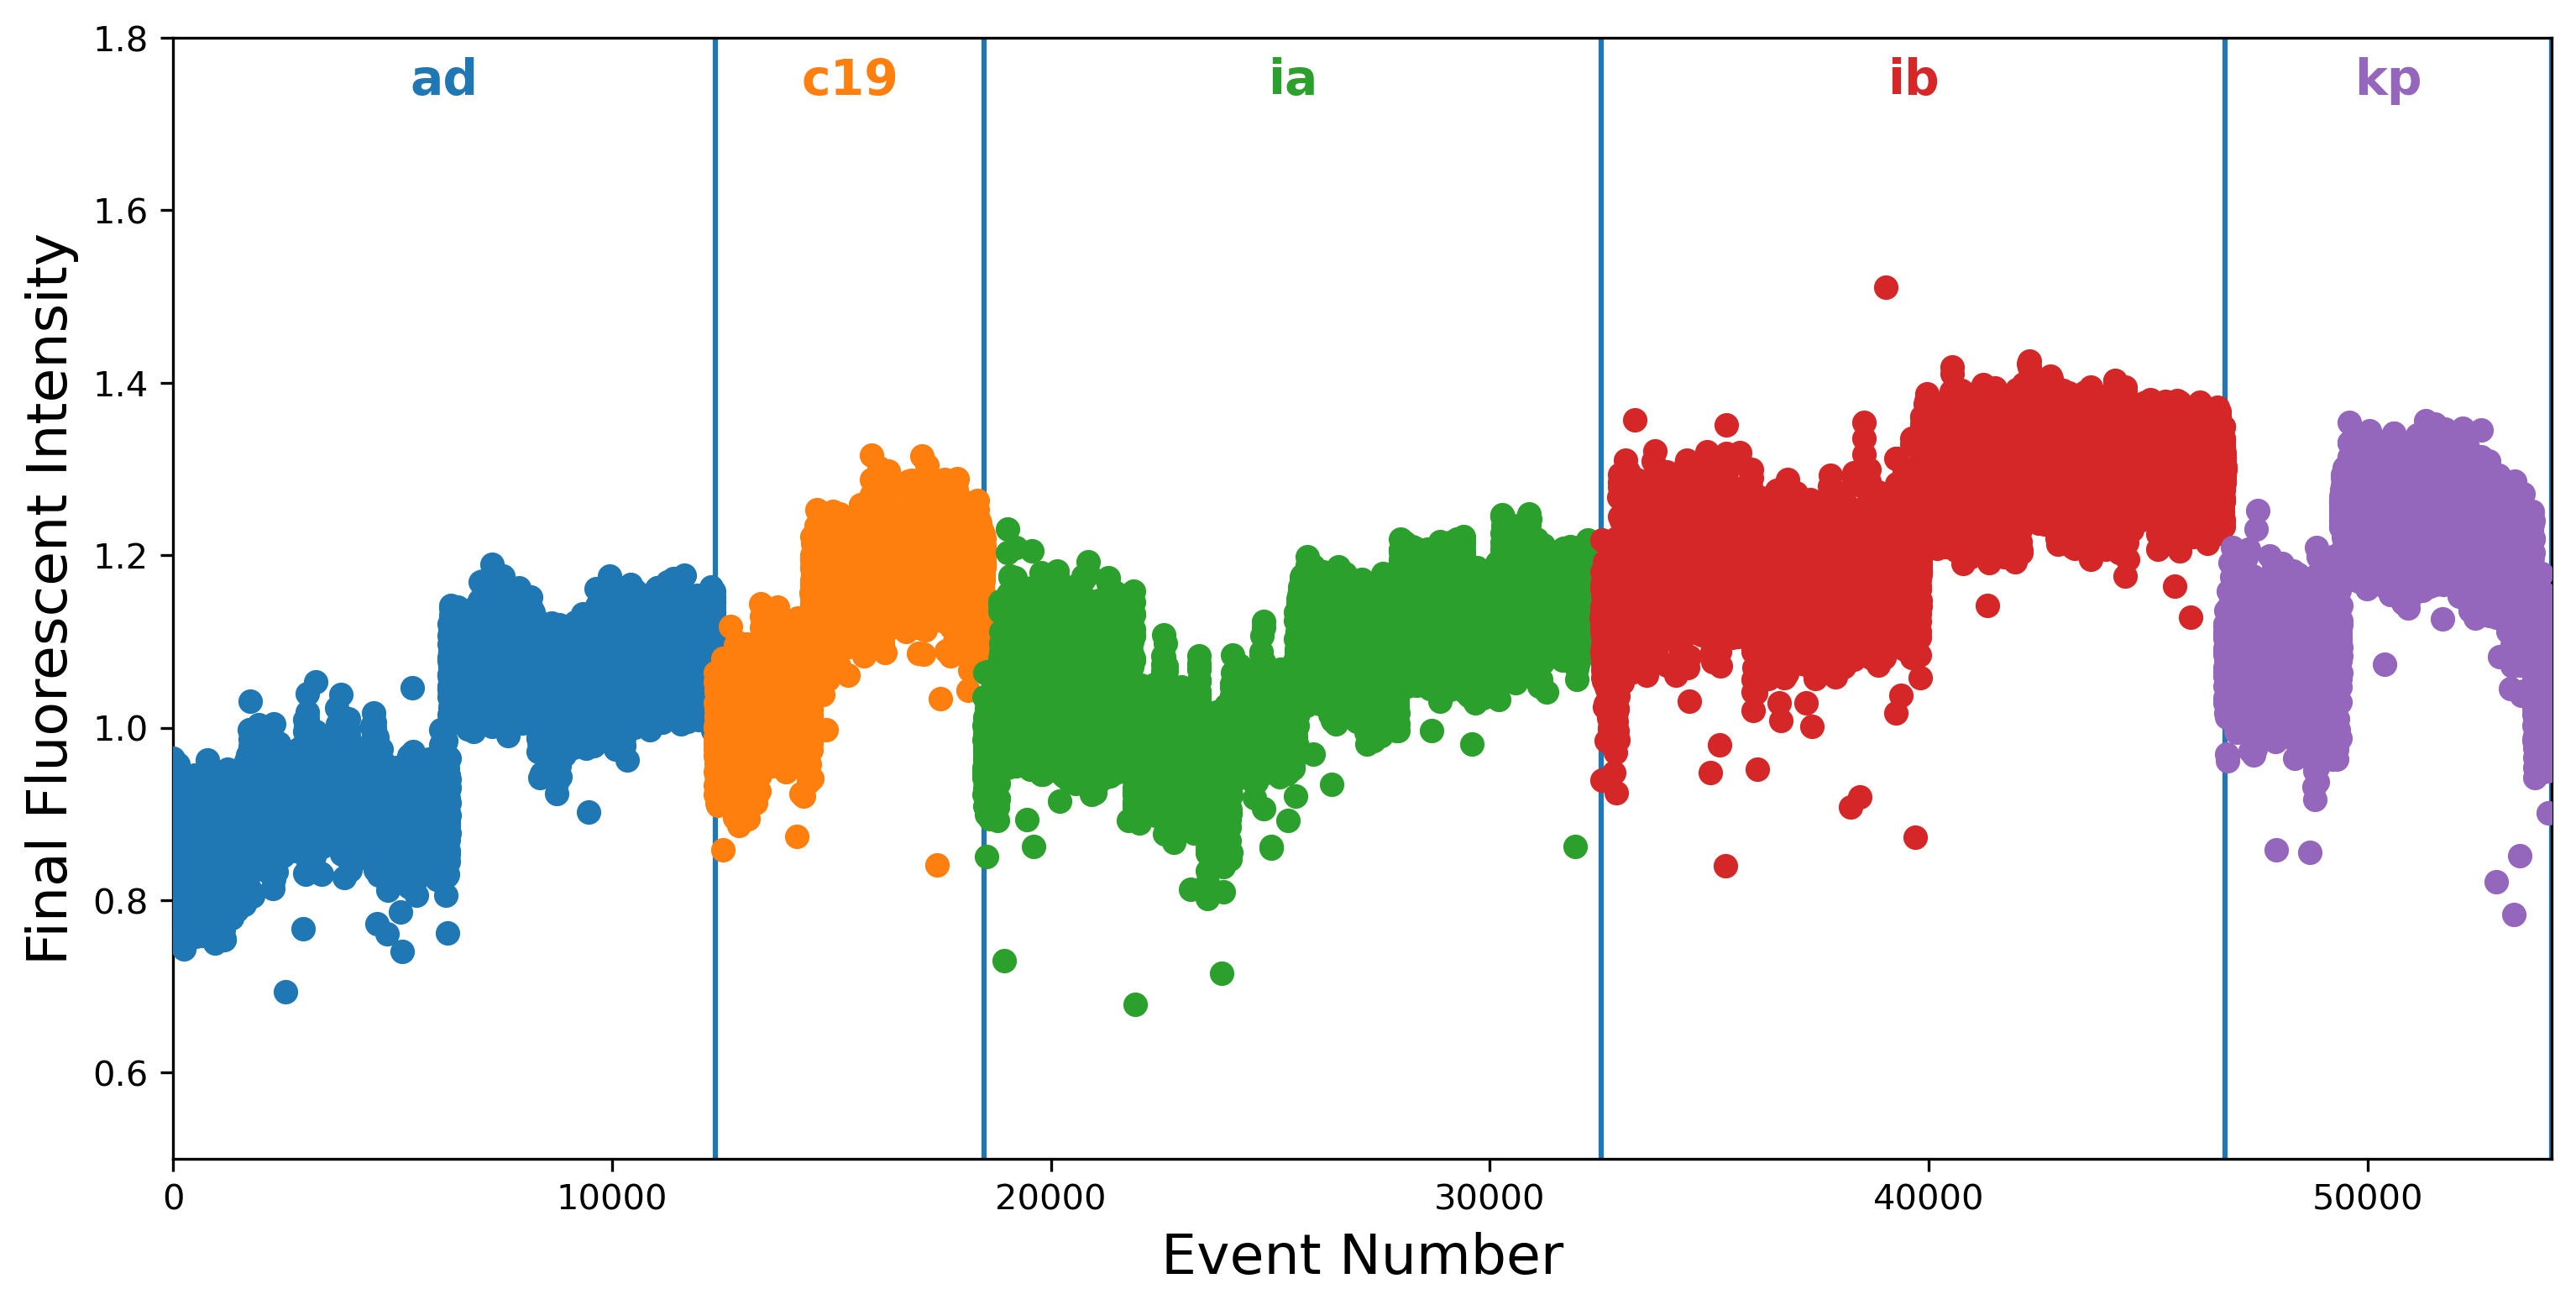

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)

cnt = 0
for i in range(5):
    idx = ytrue==i
    ax.scatter(np.arange(np.sum(idx)) + cnt, X_FFI[idx], color=f'C{i}', zorder=100)
    
    ax.text(cnt + np.sum(idx)/2, 1.75, encoder.classes_[i], color=f'C{i}', fontsize=14, weight='bold',
            horizontalalignment='center', verticalalignment='center')
    
    cnt += np.sum(idx)
    
    ax.vlines(cnt, 0.5, 1.8)
    
    
ax.set_xlim((0, len(X_FFI)))
ax.set_ylim((0.5, 1.8))

ax.set_ylabel('Final Fluorescent Intensity', fontsize=16)
ax.set_xlabel('Event Number', fontsize=16)

# ax.grid(True)
fig.savefig(f'graphs/ffi_values.pdf', bbox_inches = 'tight')
plt.tight_layout()
plt.show()

# Cross-Validation adn 1v1 class.

In [81]:
from collections import OrderedDict
from sklearn.multiclass import OneVsOneClassifier
import itertools

In [82]:
X_AC = df_master.iloc[:, NMETA+1:].values
X_MC = df_master.loc[:, ['MeltPeaks']].values    
X_FFI = df_master.iloc[:,[-1]].values
   
encoder = LabelEncoder()
encoder.fit(df_master['Target'])
ytrue = encoder.transform(df_master['Target'])

X_MC.shape, X_AC.shape, X_FFI.shape, ytrue.shape

((54186, 1), (54186, 35), (54186, 1), (54186,))

In [145]:
d = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
d_r = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
print (d_r)

{0: 'ad', 1: 'c19', 2: 'ia', 3: 'ib', 4: 'kp'}


In [84]:
target_idx = [0,1,2,3,4]
x = list(itertools.combinations(target_idx,2))
x

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

In [126]:
X = X_AC
y = ytrue
X_new = X

N_NEIGHS = 5

clf = OneVsOneClassifier(KNeighborsClassifier(n_neighbors=N_NEIGHS))
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [86]:
true_each_fold = []
pred_each_fold = []

for train_index, test_index in folds.split(X_new, y):
    X_train, X_test = X_new[train_index], X_new[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf.fit(X_train, y_train)
    
    trues = {}
    trues[(0, 1, 2, 3, 4)] = y_test

    preds = {}
    preds[(0, 1, 2, 3, 4)] = clf.predict(X_test)
    
    for model, features in zip(clf.estimators_, x):
        
        if features == (0, 1):
            preds[features] = model.predict(X_test[(y_test==features[0])|(y_test==features[1])])
        elif features == (0, 2):
            preds[features] = 2*model.predict(X_test[(y_test==features[0])|(y_test==features[1])])
        elif features == (0, 3):
            preds[features] = 3*model.predict(X_test[(y_test==features[0])|(y_test==features[1])])
        elif features == (0, 4):
            preds[features] = 4*model.predict(X_test[(y_test==features[0])|(y_test==features[1])])
        elif features == (1, 2):
            preds[features] = 1+model.predict(X_test[(y_test==features[0])|(y_test==features[1])])
        elif features == (1, 3):
            preds[features] = 1+2*model.predict(X_test[(y_test==features[0])|(y_test==features[1])])
        elif features == (1, 4):
            preds[features] = 1+3*model.predict(X_test[(y_test==features[0])|(y_test==features[1])])
        elif features == (2, 3):
            preds[features] = 2+model.predict(X_test[(y_test==features[0])|(y_test==features[1])])
        elif features == (2, 4):
            preds[features] = 2+2*model.predict(X_test[(y_test==features[0])|(y_test==features[1])])
        elif features == (3, 4):
            preds[features] = 3+model.predict(X_test[(y_test==features[0])|(y_test==features[1])])
            
        trues[features] = y_test[(y_test==features[0])|(y_test==features[1])]
        
    pred_each_fold.append(preds)
    true_each_fold.append(trues)

In [164]:
dfs = []

for i, feature in enumerate(x):
    target = d_r[feature[0]] + ' vs ' + d_r[feature[1]]
    output_individual = {}
    output_individual['y_true'] = np.concatenate([item[feature] 
                                                  for item in true_each_fold])
    output_individual['y_pred'] = np.concatenate([item[feature] 
                                                  for item in pred_each_fold])
    
    cm = confusion_matrix(output_individual['y_pred'], output_individual['y_true'])

    TP = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TN = cm[1, 1]
    
    accuracy = 100 * np.mean(output_individual['y_true']==output_individual['y_pred'])
    sensitivity = 100*TP/(TP+FN)
    specificity = 100*TN/(TN+FP)
    
    df_ = pd.DataFrame({"targets": target,
                        "accuracy":accuracy,
                        "sensitivity":sensitivity,
                        "specificity":specificity}, index=[i])
    dfs.append(df_)
    
df_final_1v1 = pd.concat(dfs)

In [167]:
# df_final_1v1.to_csv('1v1_classifier.csv')
df_final_1v1

targets   accuracy  sensitivity  specificity
0  ad vs c19  97.396764    98.737149    94.693011
1   ad vs ia  97.218122    98.316198    96.253910
2   ad vs ib  99.148776    99.878572    98.513771
3   ad vs kp  97.550134    99.417146    94.451908
4  c19 vs ia  97.033479    94.023514    98.343759
5  c19 vs ib  98.636878    98.644677    98.633514
6  c19 vs kp  91.104068    93.076421    89.481462
7   ia vs ib  98.959844    99.296275    98.626470
8   ia vs kp  97.936036    99.033267    95.862440
9   ib vs kp  98.248695    97.929140    98.858141

In [105]:
def plot_confusion_matrix2(y_true, y_pred, classes, mask, ax,
                          normalize=False, labels=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax.imshow(mask, interpolation='nearest', cmap='Greens')
    
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    
    accuracy = 100 * np.mean(y_true==y_pred)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix\n(Acc: {:.2f}%)'.format(accuracy),
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#              rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax.grid(False)
    
    return cm

################################

def plot_(features, ax, true_each_fold, pred_each_fold, names):
    output_individual = {}
    output_individual['y_true'] = np.concatenate([item[features] 
                                                  for item in true_each_fold])
    output_individual['y_pred'] = np.concatenate([item[features] 
                                                  for item in pred_each_fold])
    
    
    cm = plot_confusion_matrix2(y_true=output_individual['y_true'], 
                                y_pred=output_individual['y_pred'], 
                                classes=[names[i] for i in features],
                                mask=np.eye(len(features), len(features)),
                                ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.xticks(rotation=0)
    
    if len(features) == 2:
        TP = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]
        TN = cm[1, 1]


    #     lab = '{}' + ' vs {}'*(len(features)-1)
    #     print(lab.format(*[names[i] for i in features]))
        ax.set_title(ax.get_title()+f'\n(Sens: {100*TP/(TP+FN):.2f}%)\n(Spec: {100*TN/(TN+FP):.2f}%)')
    #     print(f'Sensitivity: {TP/(TP+FN)}')
    #     print(f'Specificity: {TN/(TN+FP)}')
    #     print('Accuracy: {}'.format((output_individual['y_true']==output_individual['y_pred']).mean()))

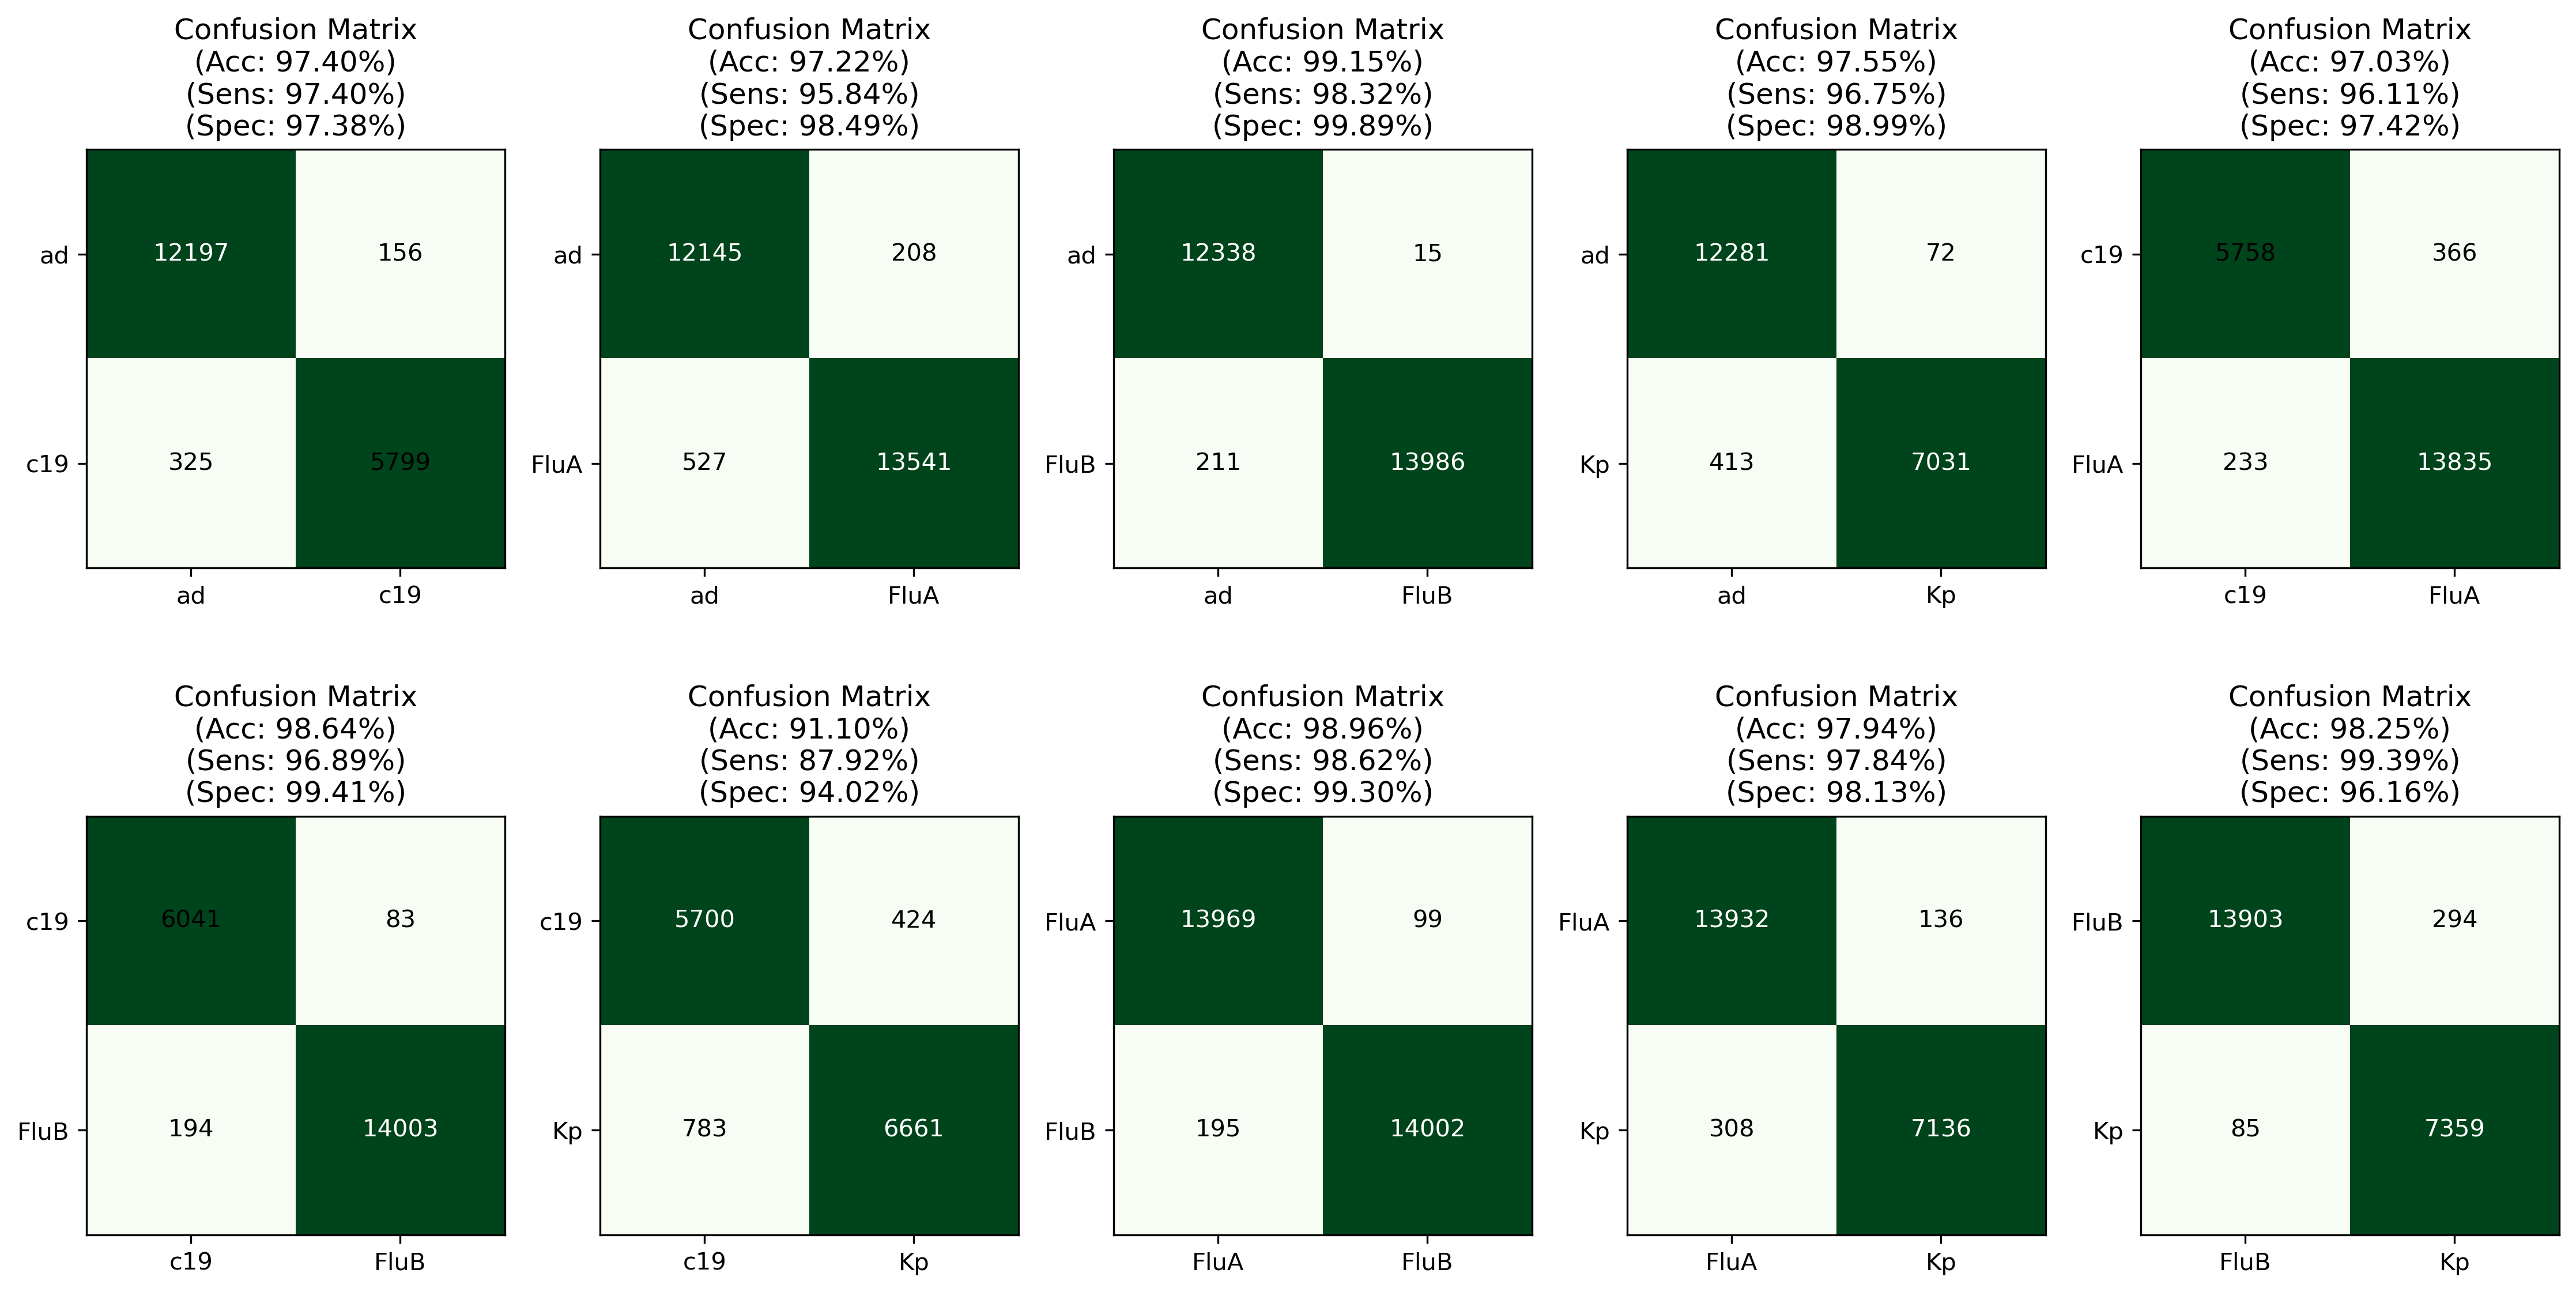

In [106]:
names = ['ad', 'c19', 'FluA', 'FluB', 'Kp']

fig, ax = plt.subplots(2, 5, figsize=(15, 8), dpi=300)
ax = ax.flatten()

for i, features in enumerate(x):
    plot_(features, ax[i], true_each_fold, pred_each_fold, names)

plt.tight_layout()
plt.show()

# 1. 2X2 K-fold Matrix

In [8]:
N_SPLITS = 10 
FAKE_AC = False
FAKE_MC = False
NN = False

y_trues = []
y_preds = []  

y_preds_AC = []
y_preds_MC = []
y_preds_FFI = []


skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)

for i, (train_index, test_index) in enumerate(skf.split(X_AC, ytrue)):
    
    X_MC_train, X_MC_test = X_MC[train_index], X_MC[test_index]
    X_AC_train, X_AC_test = X_AC[train_index], X_AC[test_index]
    X_FFI_train, X_FFI_test = X_FFI[train_index], X_FFI[test_index]
    
    y_train, y_test = ytrue[train_index], ytrue[test_index]
    
    ########## create/train model for MC ##########    
    clf_MC, clf_MC_proba = mlfunc.train_MCA_model(X_MC_train, y_train, FAKE_MC)
    
    ########## create/train model for AC ##########
    clf_AC, clf_AC_proba = mlfunc.train_ACA_model(X_AC_train, y_train, FAKE_AC, NN)
    
    ########## create/train model for FFI ##########
    clf_FFI, clf_FFI_proba = mlfunc.train_FFI_model(X_FFI_train, y_train)
       
        
    ########## create/train model for AMCA ##########
    X_AC_MC_train = np.concatenate((clf_MC_proba, clf_AC_proba), axis=1)
    clf, clf_proba = mlfunc.train_AMCA_model(X_AC_MC_train, y_train)

        
    if NN:
        X_AC_MC_test = np.concatenate((clf_MC.predict_proba(X_MC_test), 
                                       clf_AC.predict(X_AC_test)), axis=1)
    
    else:    
        X_AC_MC_test = np.concatenate((clf_MC.predict_proba(X_MC_test), 
                                       clf_AC.predict_proba(X_AC_test)), axis=1)
    
    y_pred = clf.predict(X_AC_MC_test)
    
    y_preds.append( y_pred )
    y_trues.append( y_test )
    
    if NN:
        y_preds_AC.append( clf_AC.predict(X_AC_test).argmax(axis=1) )
        
        
    else:
        y_preds_AC.append( clf_AC.predict(X_AC_test) )
    
    y_preds_MC.append( clf_MC.predict(X_MC_test) )
    y_preds_FFI.append( clf_FFI.predict(X_FFI_test) )
    
    
y_trues = np.concatenate(y_trues)
y_preds = np.concatenate(y_preds)

y_preds_AC = np.concatenate(y_preds_AC)
y_preds_MC = np.concatenate(y_preds_MC)
y_preds_FFI = np.concatenate(y_preds_FFI)

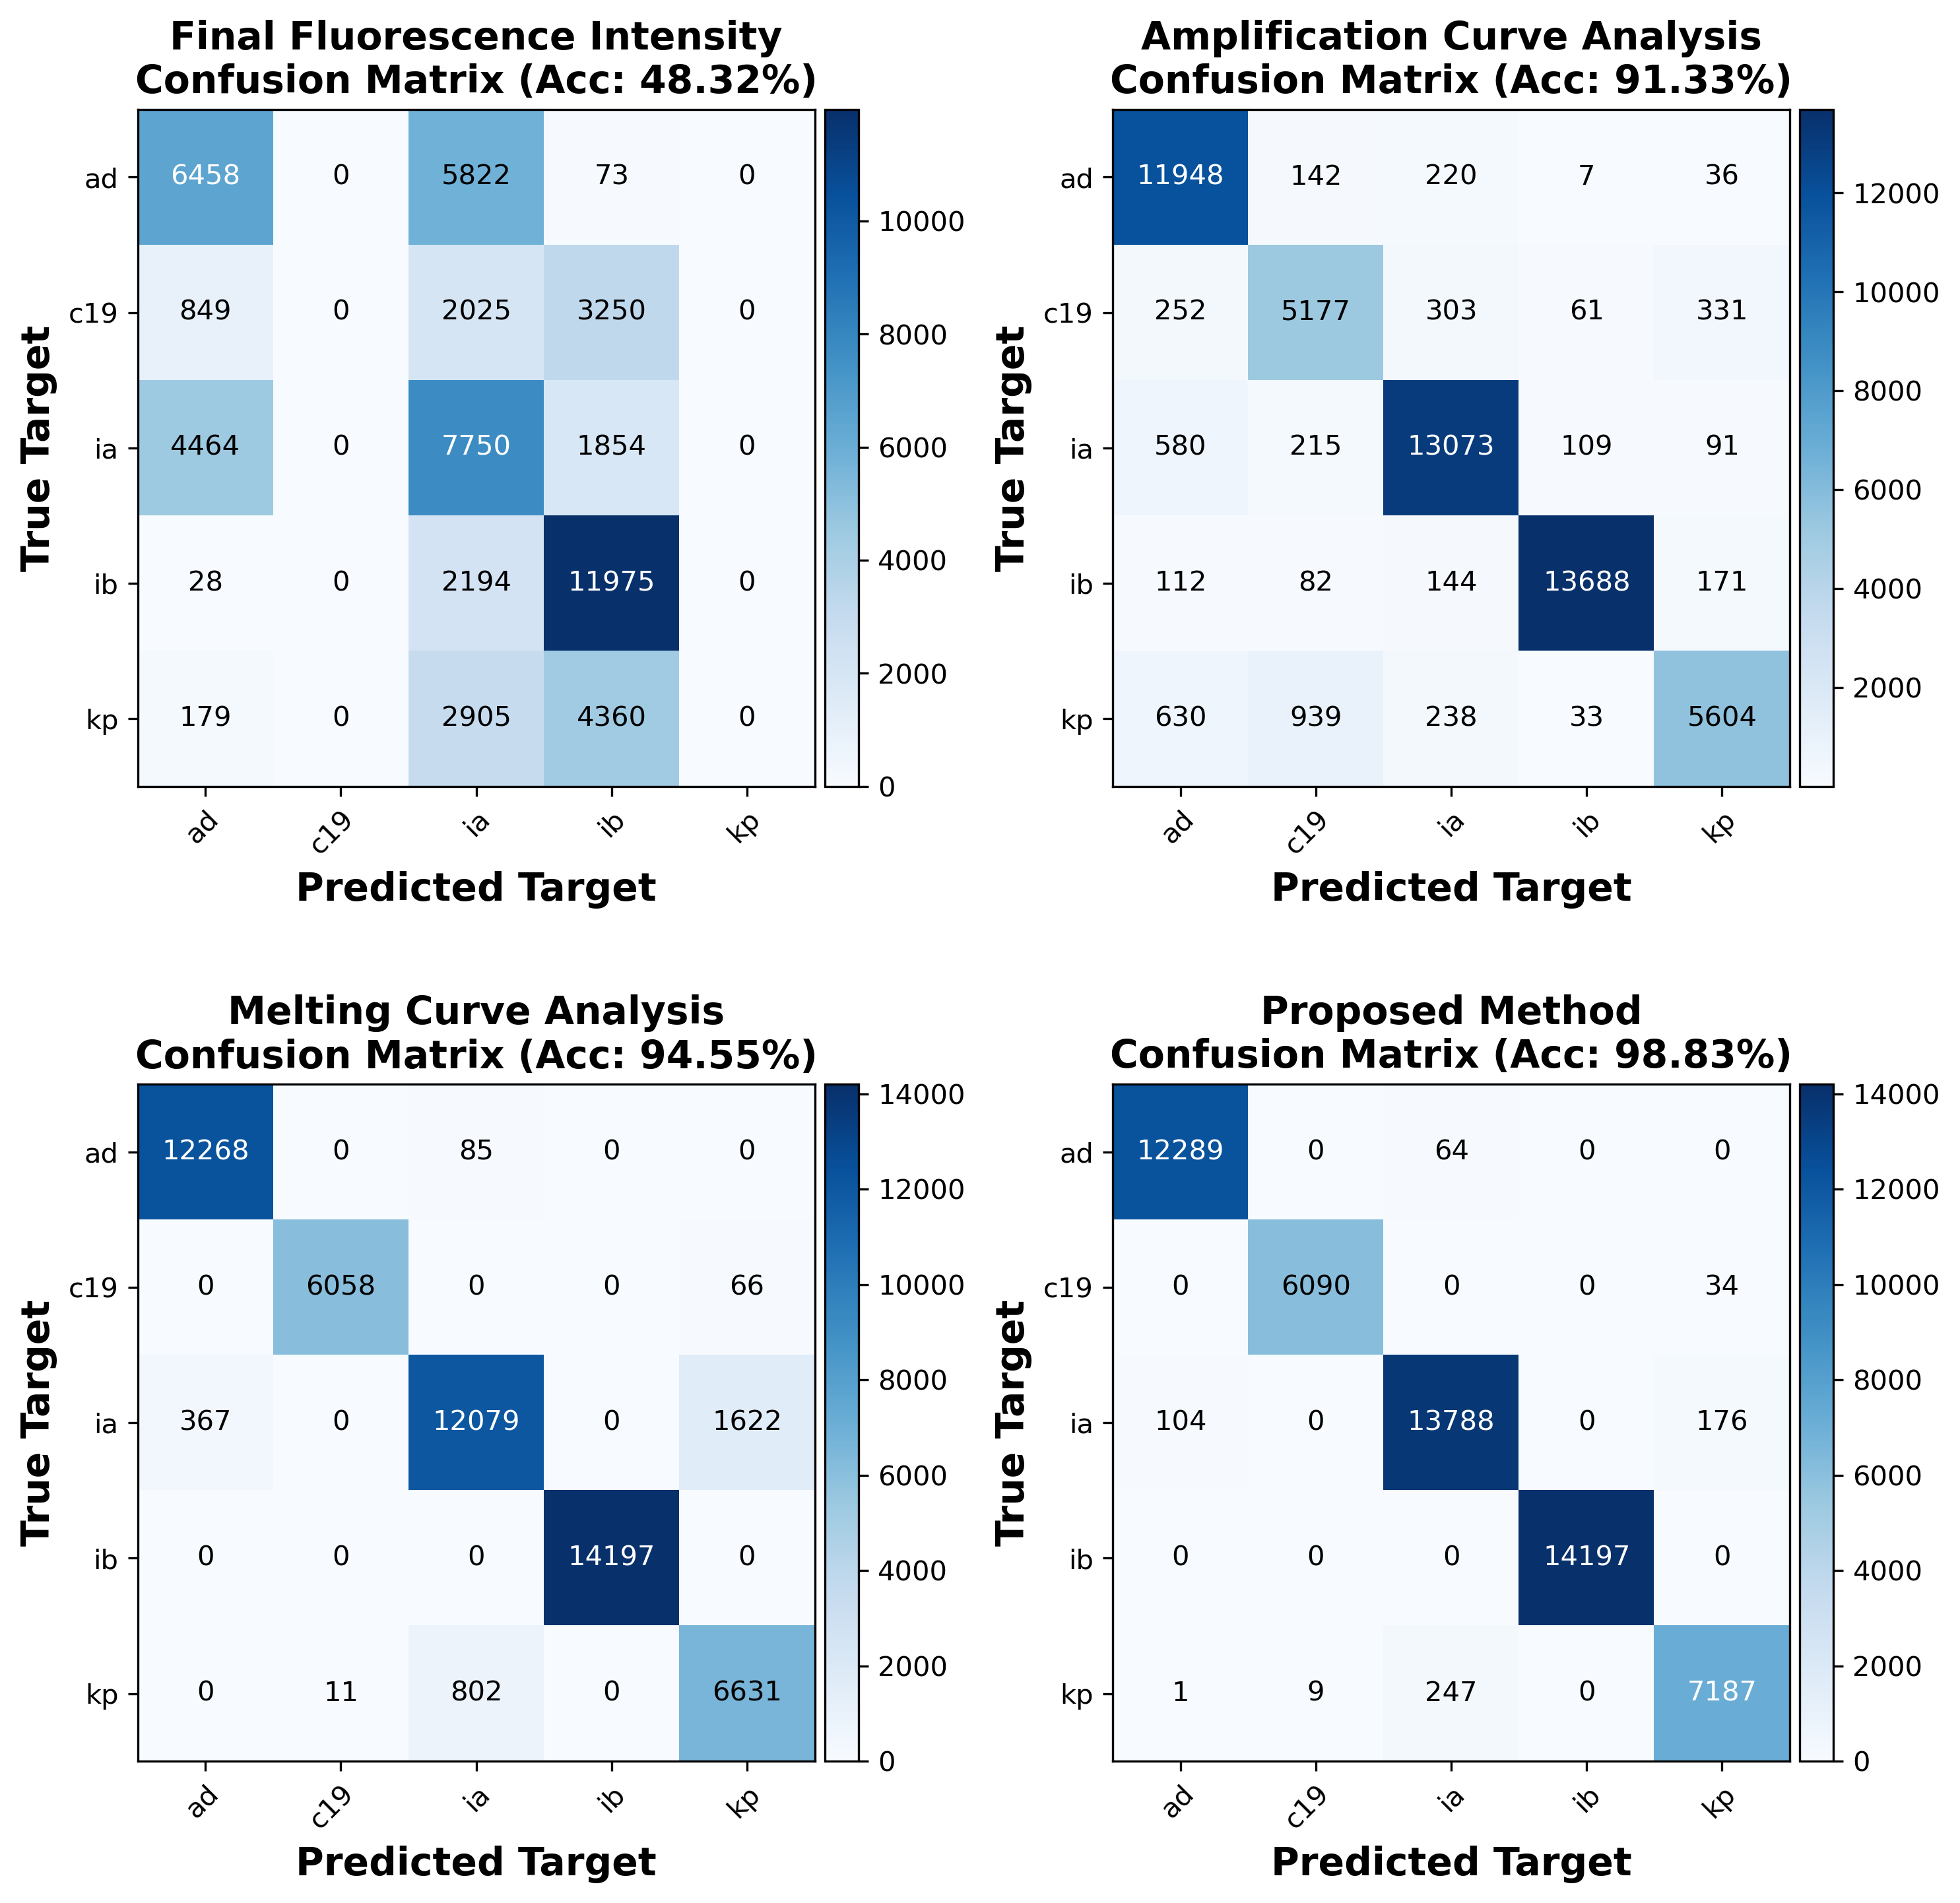

In [9]:
classes = encoder.classes_

fig, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=300)
ax = ax.flatten()

plotfunc.plot_confusion_matrix(y_trues, y_preds_FFI, classes, ax[0], normalize=False)
ax[0].set_title('Final Fluorescence Intensity\n'+ax[0].get_title(), fontsize=14, weight='bold')
ax[0].set_ylabel('True Target', fontsize=14, weight='bold')
ax[0].set_xlabel('Predicted Target', fontsize=14, weight='bold')

plotfunc.plot_confusion_matrix(y_trues, y_preds_AC, classes, ax[1], normalize=False)
ax[1].set_title('Amplification Curve Analysis\n'+ax[1].get_title(), fontsize=14, weight='bold')
ax[1].set_ylabel('True Target', fontsize=14, weight='bold')
ax[1].set_xlabel('Predicted Target', fontsize=14, weight='bold')
plotfunc.plot_confusion_matrix(y_trues, y_preds_MC, classes, ax[2], normalize=False)
ax[2].set_title('Melting Curve Analysis\n'+ax[2].get_title(), fontsize=14, weight='bold')
ax[2].set_ylabel('True Target', fontsize=14, weight='bold')
ax[2].set_xlabel('Predicted Target', fontsize=14, weight='bold')

plotfunc.plot_confusion_matrix(y_trues, y_preds, classes, ax[3], normalize=False)
ax[3].set_title('Proposed Method\n'+ax[3].get_title(), fontsize=14, weight='bold')
ax[3].set_ylabel('True Target', fontsize=14, weight='bold')
ax[3].set_xlabel('Predicted Target', fontsize=14, weight='bold')

plt.tight_layout()
fig.savefig(f'graphs/kfold_matrix.pdf', bbox_inches = 'tight')
plt.show()

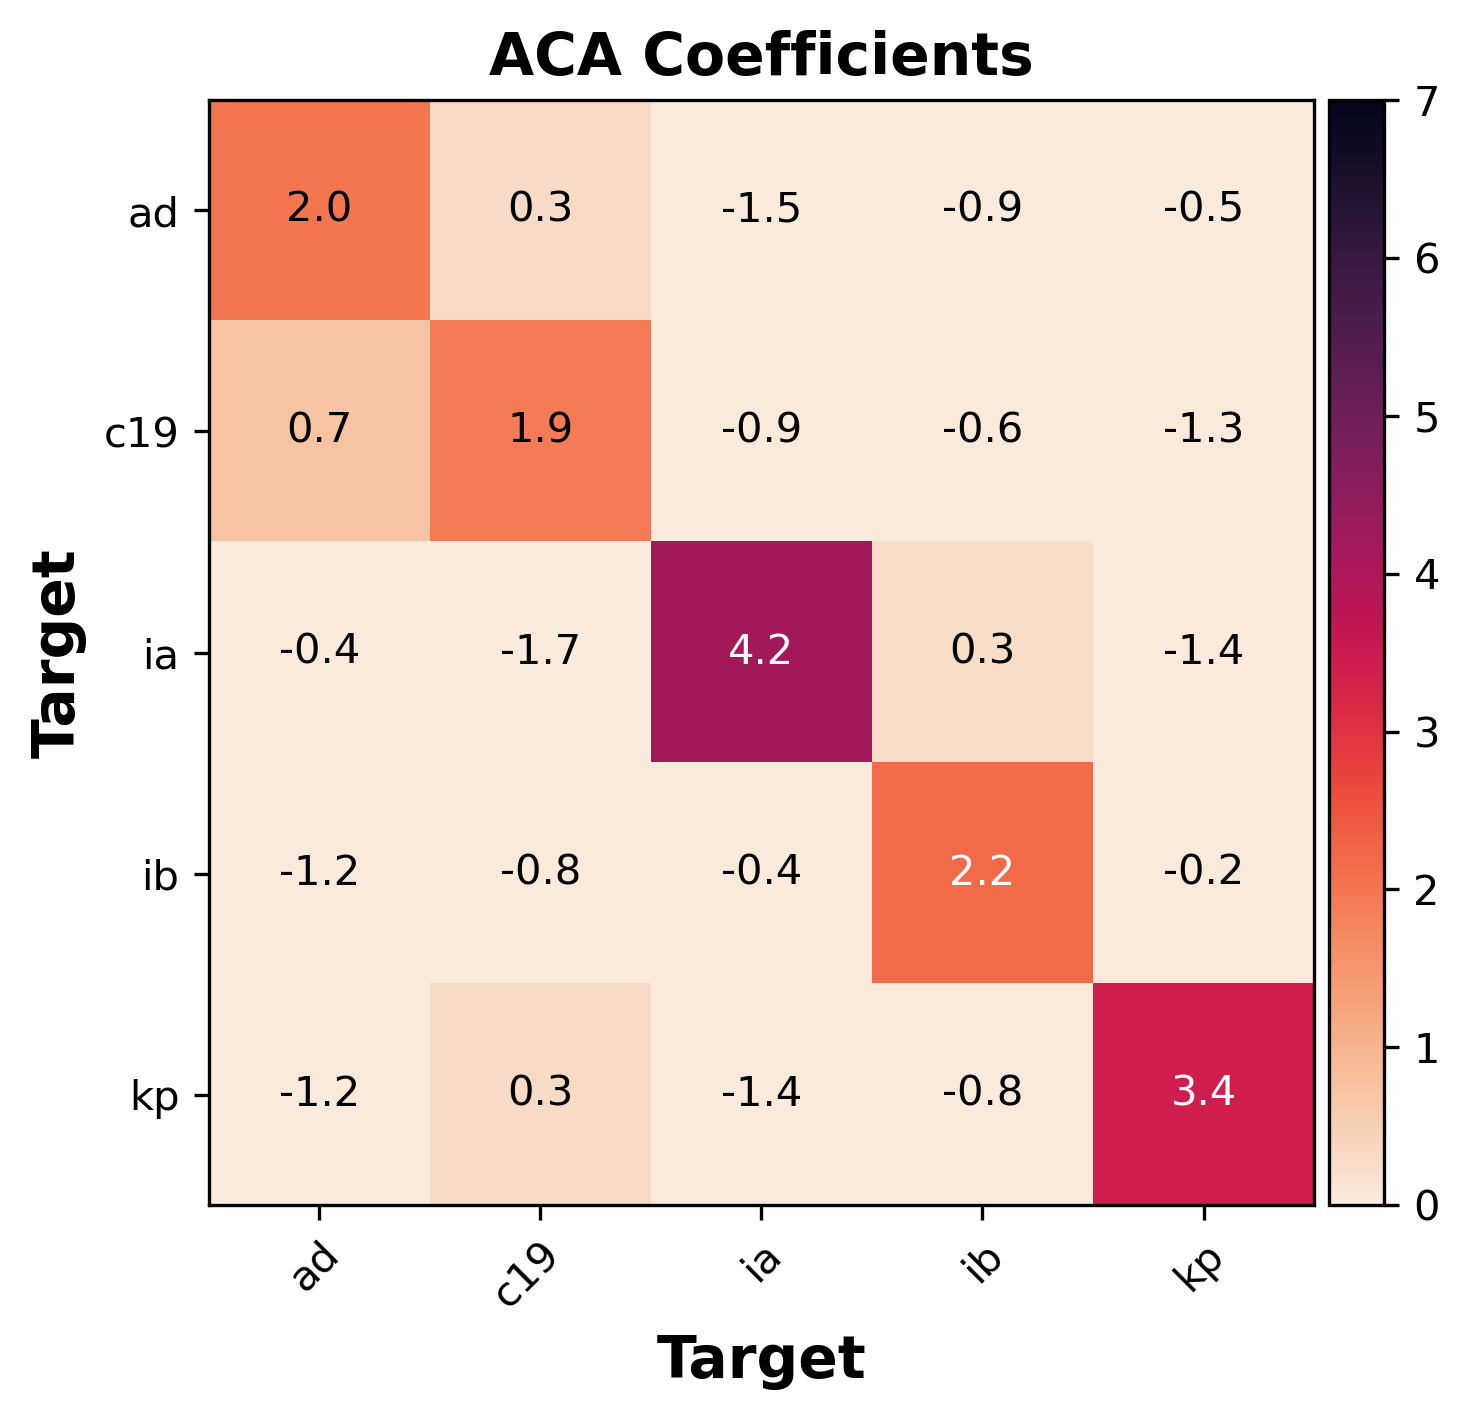

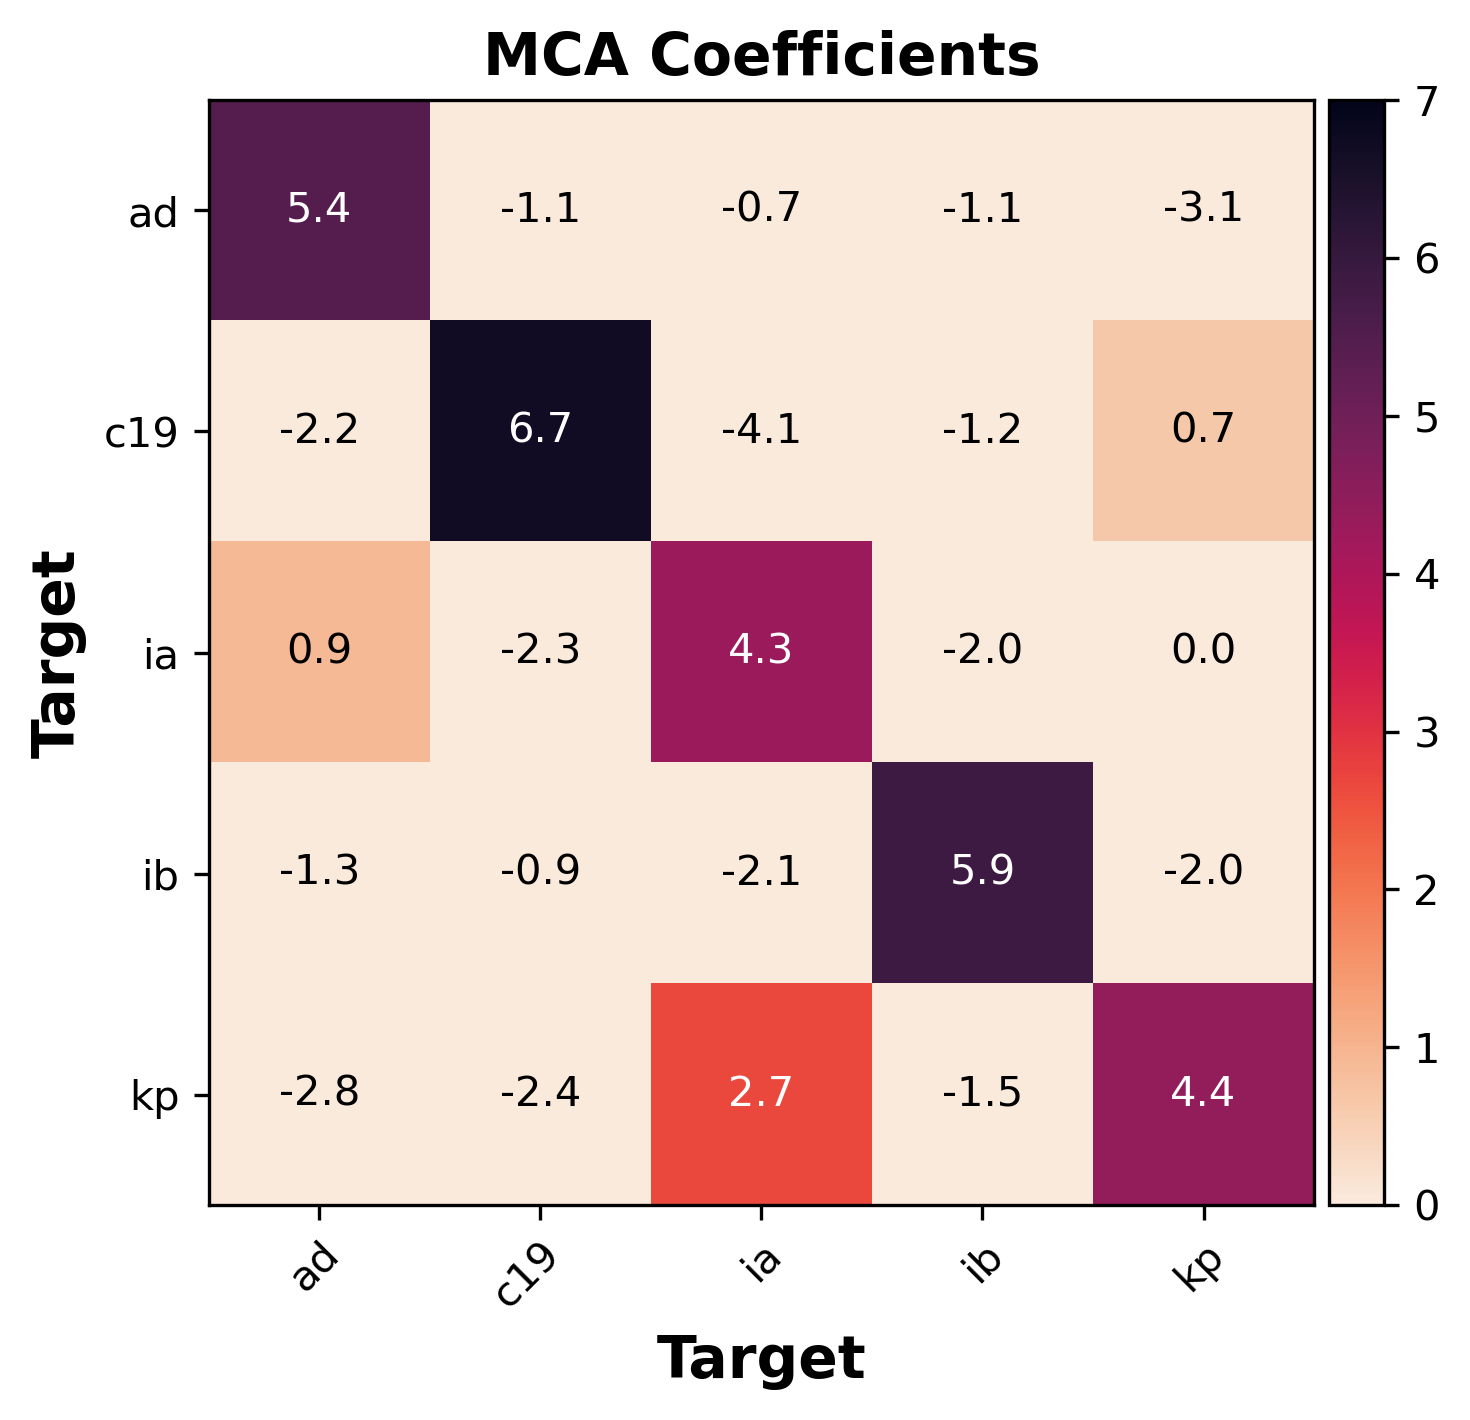

In [10]:
MCA_coef = clf.coef_[:,:5]
ACA_coef = clf.coef_[:,-5:]
    
coefs = [ACA_coef, MCA_coef]
short_names = ['ACA', 'MCA']
    
for coef, short_name in zip(coefs, short_names):
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)

    ax.set_xticks(range(5))
    ax.set_yticks(range(5))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    utils.my_heatmap(coef, ax, sns.cm.rocket_r)
    ax.set_title(f'{short_name} Coefficients', fontsize=14, weight='bold')
    ax.set_ylabel('Target', fontsize=14, weight='bold')
    ax.set_xlabel('Target', fontsize=14, weight='bold')

    plt.tight_layout()
    fig.savefig(f'graphs/{short_name}_coeff.pdf', bbox_inches = 'tight')
    plt.show()

# 2. TSNE

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [12]:
df_master.Exp_id.unique()

array(['20201202_01', '20210201_01', '20210209_01'], dtype=object)

In [13]:
df_single = df_master[df_master.Exp_id == '20210209_01']
df_single

Channel PrimerMix Target Assay      Conc       Exp_id  MeltPeaks  \
13868  panel19   5plex_A     ad   RM5  10000000  20210209_01  89.983687   
13873  panel19   5plex_A     ad   RM5  10000000  20210209_01  90.193481   
13880  panel19   5plex_A     ad   RM5  10000000  20210209_01  90.327284   
13885  panel19   5plex_A     ad   RM5  10000000  20210209_01  90.320230   
13894  panel19   5plex_A     ad   RM5  10000000  20210209_01  90.241806   
...        ...       ...    ...   ...       ...          ...        ...   
97015  panel48   5plex_A     kp   RM5  10000000  20210209_01  88.793187   
97016  panel48   5plex_A     kp   RM5  10000000  20210209_01  88.525847   
97017  panel48   5plex_A     kp   RM5  10000000  20210209_01  88.848588   
97018  panel48   5plex_A     kp   RM5  10000000  20210209_01  88.787802   
97019  panel48   5plex_A     kp   RM5  10000000  20210209_01  88.868744   

            1.0       2.0       3.0  ...      26.0      27.0      28.0  \
13868  0.000453  0.000173 -0.000626  ...  1.088429  1.089894  1.092750   
13873 -0.000257 -0.000623  0.000880  ...  1.051809  1.053043  1.055025   
13880 -0.000149 -0.000176  0.000325  ...  0.953290  0.976598  0.985138   
13885 -0.000330 -0.000575  0.000905  ...  1.008853  1.016472  1.021756   
13894 -0.000508 -0.000592  0.001099  ...  1.030156  1.034823  1.039215   
...         ...       ...       ...  ...       ...       ...       ...   
97015  0.000730 -0.000174 -0.000557  ...  1.170685  1.168441  1.166655   
97016  0.000962 -0.000209 -0.000753  ...  1.157382  1.155568  1.152235   
97017 -0.000196 -0.000085  0.000281  ...  1.159740  1.155361  1.149665   
97018  0.000079 -0.000119  0.000041  ...  1.179409  1.180909  1.179711   
97019 -0.000917 -0.000285  0.001203  ...  0.651274  0.886210  1.034360   

           29.0      30.0      31.0      32.0      33.0      34.0      35.0  
13868  1.095523  1.097924  1.098743  1.099474  1.100048  1.103016  1.107167  
13873  1.058051  1.059802  1.060869  1.060707  1.060928  1.061321  1.061709  
13880  0.996108  1.005743  1.018006  1.028201  1.039601  1.043516  1.044603  
13885  1.027152  1.027758  1.028840  1.029249  1.030152  1.031940  1.035663  
13894  1.045328  1.048407  1.048568  1.046404  1.046163  1.047391  1.048676  
...         ...       ...       ...       ...       ...       ...       ...  
97015  1.165170  1.164437  1.162612  1.160350  1.158547  1.160580  1.164904  
97016  1.147697  1.145869  1.146824  1.151070  1.154468  1.156903  1.156163  
97017  1.144834  1.142319  1.142781  1.144975  1.145206  1.143472  1.140744  
97018  1.174419  1.168214  1.164950  1.166054  1.168061  1.170165  1.170562  
97019  1.084424  1.099912  1.114742  1.124779  1.131547  1.136848  1.140448  

[28254 rows x 42 columns]

In [14]:
tsne = TSNE(n_components=3, verbose=1, perplexity=100, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(df_single.iloc[:, NMETA+1:])

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 28254 samples in 0.001s...
[t-SNE] Computed neighbors for 28254 samples in 11.938s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28254
[t-SNE] Computed conditional probabilities for sample 2000 / 28254
[t-SNE] Computed conditional probabilities for sample 3000 / 28254
[t-SNE] Computed conditional probabilities for sample 4000 / 28254
[t-SNE] Computed conditional probabilities for sample 5000 / 28254
[t-SNE] Computed conditional probabilities for sample 6000 / 28254
[t-SNE] Computed conditional probabilities for sample 7000 / 28254
[t-SNE] Computed conditional probabilities for sample 8000 / 28254
[t-SNE] Computed conditional probabilities for sample 9000 / 28254
[t-SNE] Computed conditional probabilities for sample 10000 / 28254
[t-SNE] Computed conditional probabilities for sample 11000 / 28254
[t-SNE] Computed conditional probabilities for sample 12000 / 28254
[t-SNE] Computed conditional probabilities for s

In [15]:
df_red = df_single.iloc[:, [2]]

df_red['3d-one'] = tsne_results[:,0]
df_red['3d-two'] = tsne_results[:,1]
df_red['3d-three'] = tsne_results[:,2]

df_red

/Users/Luca/opt/anaconda3/envs/MultiplexAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Luca/opt/anaconda3/envs/MultiplexAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/Luca/opt/anaconda3/envs/MultiplexAnalysis/lib/python3.7/site-packages/ipykernel_launcher.py

Target     3d-one     3d-two   3d-three
13868     ad   3.881509 -10.196668  -4.957171
13873     ad -10.727782 -12.167377  -4.266229
13880     ad  11.505963   7.943433  -7.476413
13885     ad  13.771187  -1.939480  -0.251302
13894     ad  14.585242   1.065233  -4.002750
...      ...        ...        ...        ...
97015     kp -12.313143   2.391742 -10.127503
97016     kp   2.197567  -8.700519 -10.650839
97017     kp  -3.885797  11.184694  -4.628285
97018     kp  -8.060101  10.672462  -3.752332
97019     kp  17.095190  11.882714  -2.622881

[28254 rows x 4 columns]

In [16]:
fig = px.scatter_3d(df_red.sample(500, random_state=0), x='3d-one', y='3d-two', z = '3d-three',
              color='Target', hover_data=['Target'])

fig.show()

### UMAP


In [17]:
df_single.Exp_id.unique()

array(['20210209_01'], dtype=object)

In [18]:
# !pip install umap-learn
import umap

In [19]:
reducer = umap.UMAP(n_components=3)

In [20]:
df_data = df_single.iloc[:, NMETA+1:]

scaled_data = StandardScaler().fit_transform(df_data)

In [21]:
embedding = reducer.fit_transform(scaled_data)
embedding.shape

(28254, 3)

In [22]:
df_red_u = df_single.iloc[:, [2]].reset_index(drop=True)

df_red_u['one'] = embedding[:,0]
df_red_u['two'] = embedding[:,1]
df_red_u['three'] = embedding[:,2]

df_red_u

Target        one        two     three
0         ad  11.075830   7.181568 -2.122593
1         ad   9.501557   7.113044 -4.261786
2         ad  10.312070  11.480060  5.425561
3         ad   9.869141   8.952894 -2.233556
4         ad   9.924170   9.164117 -1.203429
...      ...        ...        ...       ...
28249     kp  10.905126   2.895144 -0.646227
28250     kp  10.696268   5.579913 -0.990863
28251     kp  10.391294  -1.459793  4.526684
28252     kp  10.294537  -1.037692  2.926263
28253     kp  10.362775  10.941386  8.384581

[28254 rows x 4 columns]

In [23]:
fig = px.scatter_3d(df_red_u.sample(1000, random_state=0), x='one', y='two', z='three',
                    color='Target', hover_data=['Target'])

fig.update_traces(marker=dict(size=3))

# fig = plt.scatter(df_red_u.sample(1000, random_state=0), x='one', y='two', z='three',
#                     color='Target', hover_data=['Target'])

fig.show()

### Obtain t/p-values

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
df_ib = df_red_u[df_red_u.Target=='ib']
df_ad = df_red_u[df_red_u.Target=='ad']

In [ ]:
df_ib.iloc[:, 1:].values

In [ ]:
t, p = ttest_ind(df_ib.iloc[:, 1:].values, df_ad.iloc[:, 1:].values)

In [ ]:
t, p

# 3. Training Positives vs Test Performance 

### Single Exp

In [ ]:
df_single = df_master[df_master.Exp_id=='20210201_01']
df_single

In [ ]:
X_AC = df_single.iloc[:, 7:].values
X_MC = df_single.loc[:, ['MeltPeaks']].values
X_FFI = X_AC[:,[-1]]

encoder = LabelEncoder()
ytrue = encoder.fit_transform(df_single['Target'])

X_MC.shape, X_AC.shape, X_FFI.shape, ytrue.shape

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

n_total = len(X_AC)
assert len(X_AC)==len(X_MC)==len(X_FFI), "Something is wrong!"

n_repeat = 5
n_train_sizes = 35
test_size = 7500

train_size = (10**np.linspace(2, np.log10(n_total-test_size), num=n_train_sizes))/n_total
# train_size = np.linspace(50, n_total-test_size, num=n_train_sizes) / n_total

accuracy = pd.DataFrame(columns = ['Method', 'TrainSize', 'Train/Test', 'Accuracy', 'Repeat ID'])

for size in tqdm(train_size, desc='Train Size Split'):
    
    sss = StratifiedShuffleSplit(n_splits=n_repeat, test_size=test_size/n_total, random_state=5)

    for split_id, (train_index, test_index) in tqdm(enumerate(sss.split(X_AC, ytrue)), 
                                                    total=n_repeat, desc='Repeat', leave=False):
        
        X_MC_train, X_MC_test = X_MC[train_index], X_MC[test_index]
        X_AC_train, X_AC_test = X_AC[train_index], X_AC[test_index]
        X_FFI_train, X_FFI_test = X_FFI[train_index], X_FFI[test_index]

        y_train, y_test = ytrue[train_index], ytrue[test_index]

        X_MC_train = X_MC_train[:int(len(X_MC_train)*size), :]
        X_AC_train = X_AC_train[:int(len(X_AC_train)*size), :]
        X_FFI_train = X_FFI_train[:int(len(X_FFI_train)*size), :]
        y_train = y_train[:int(len(y_train)*size)]

        ########## create/train model for MC ##########    
        clf_MC = LogisticRegression(max_iter=1000, solver='lbfgs', 
                                    multi_class='auto')
        clf_MC.fit(X_MC_train, y_train)
        clf_MC_proba = clf_MC.predict_proba(X_MC_train)

        ########## create/train model for AC ##########
        # clf_AC = myWrapper(build_fn=create_model, 
        #                         epochs=800, 
        #                         batch_size=512, 
        #                         shuffle=True,
        #                         verbose=False)

        clf_AC = KNeighborsClassifier(n_neighbors=10)
        clf_AC.fit(X_AC_train, y_train)
        clf_AC_proba = clf_AC.predict_proba(X_AC_train)

        ########## create/train model for FFI ##########
        clf_FFI = LogisticRegression(max_iter=1000, solver='lbfgs', 
                                    multi_class='auto')
        clf_FFI.fit(X_FFI_train, y_train)
        clf_FFI_proba = clf_FFI.predict_proba(X_FFI_train)

        ########## create/train model for AMCA ##########
        X_AMCA_train = np.concatenate((clf_MC_proba, clf_AC_proba), axis=1)

        clf = LogisticRegression(max_iter=1000, fit_intercept=False, 
                                 solver='lbfgs', multi_class='auto')
    #     clf = LogisticRegressionCV(max_iter=2000, fit_intercept=False,
    #                                cv=StratifiedKFold(n_splits=5, shuffle=True))

        clf.fit(X_AMCA_train, y_train)
        clf_proba = clf.predict_proba(X_AMCA_train)

        # clf_MC_proba.argmax(axis=1) is the same as clf_MC.predict(X_MC_train)
        MCA_train_accuracy = (clf_MC_proba.argmax(axis=1)==y_train).mean()
        ACA_train_accuracy = (clf_AC_proba.argmax(axis=1)==y_train).mean()
        FFI_train_accuracy = (clf_FFI_proba.argmax(axis=1)==y_train).mean()
        AMCA_train_accuracy = (clf_proba.argmax(axis=1)==y_train).mean()
            
        MCA_test_accuracy = (clf_MC.predict(X_MC_test)==y_test).mean()
        ACA_test_accuracy = (clf_AC.predict(X_AC_test)==y_test).mean()
        FFI_test_accuracy = (clf_FFI.predict(X_FFI_test)==y_test).mean()
        
        X_AMCA_test = np.concatenate((clf_MC.predict_proba(X_MC_test), 
                                      clf_AC.predict_proba(X_AC_test)), axis=1)
        AMCA_test_accuracy = (clf.predict(X_AMCA_test)==y_test).mean()
    
                
        df_ = pd.DataFrame({'Method': ['MCA', 'MCA', 'ACA', 'ACA', 'FFI', 'FFI', 'AMCA', 'AMCA'],
                      'TrainSize': [len(y_train) for i in range(8)],
                      'Train/Test': ['Train', 'Test']*4,
                      'Accuracy': [MCA_train_accuracy, MCA_test_accuracy, 
                                   ACA_train_accuracy, ACA_test_accuracy, 
                                   FFI_train_accuracy, FFI_test_accuracy, 
                                   AMCA_train_accuracy, AMCA_test_accuracy],
                      'Repeat ID': [split_id for i in range(8)]
                     })
                
        accuracy = accuracy.append(df_, ignore_index=True)

In [ ]:
methods = ['FFI', 'ACA', 'MCA', 'AMCA']

fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), dpi=100)

ax.set_title('Test Performance', fontsize=14, weight='bold')
for i, method in enumerate(methods):
    df_ = accuracy[accuracy['Method'] == method]
    
    sns.lineplot(x="TrainSize", y="Accuracy", 
                 data=df_[df_['Train/Test'] == 'Test'], 
                 label=method, ci='sd', ax=ax)

ax.set_ylabel('Classification Accuracy', fontsize=14, weight='bold')
ax.set_xlabel('Number of Training Positives', fontsize=14, weight='bold')
ax.set_ylim((0., 1.0))
ax.set_xscale('log')
ax.grid(which="both", axis="both")
ax.get_legend()

# plt.subplots_adjust(wspace=0.2)
plt.tight_layout()
fig.savefig(f'graphs/train_pos_vs_acc.pdf', bbox_inches = 'tight')
plt.show()

### All Exp

In [ ]:
X_AC = df_master.iloc[:, 7:].values
X_MC = df_master.loc[:, ['MeltPeaks']].values
X_FFI = X_AC[:,[-1]]

encoder = LabelEncoder()
ytrue = encoder.fit_transform(df_master['Target'])

X_MC.shape, X_AC.shape, X_FFI.shape, ytrue.shape

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

n_total = len(X_AC)
assert len(X_AC)==len(X_MC)==len(X_FFI), "Something is wrong!"

n_repeat = 5
n_train_sizes = 35
test_size = 7500

train_size = (10**np.linspace(2, np.log10(n_total-test_size), num=n_train_sizes))/n_total
# train_size = np.linspace(50, n_total-test_size, num=n_train_sizes) / n_total

accuracy = pd.DataFrame(columns = ['Method', 'TrainSize', 'Train/Test', 'Accuracy', 'Repeat ID'])

for size in tqdm(train_size, desc='Train Size Split'):
    
    sss = StratifiedShuffleSplit(n_splits=n_repeat, test_size=test_size/n_total, random_state=5)

    for split_id, (train_index, test_index) in tqdm(enumerate(sss.split(X_AC, ytrue)), 
                                                    total=n_repeat, desc='Repeat', leave=False):
        
        X_MC_train, X_MC_test = X_MC[train_index], X_MC[test_index]
        X_AC_train, X_AC_test = X_AC[train_index], X_AC[test_index]
        X_FFI_train, X_FFI_test = X_FFI[train_index], X_FFI[test_index]

        y_train, y_test = ytrue[train_index], ytrue[test_index]

        X_MC_train = X_MC_train[:int(len(X_MC_train)*size), :]
        X_AC_train = X_AC_train[:int(len(X_AC_train)*size), :]
        X_FFI_train = X_FFI_train[:int(len(X_FFI_train)*size), :]
        y_train = y_train[:int(len(y_train)*size)]

        ########## create/train model for MC ##########    
        clf_MC = LogisticRegression(max_iter=1000, solver='lbfgs', 
                                    multi_class='auto')
        clf_MC.fit(X_MC_train, y_train)
        clf_MC_proba = clf_MC.predict_proba(X_MC_train)

        ########## create/train model for AC ##########
        # clf_AC = myWrapper(build_fn=create_model, 
        #                         epochs=800, 
        #                         batch_size=512, 
        #                         shuffle=True,
        #                         verbose=False)

        clf_AC = KNeighborsClassifier(n_neighbors=10)
        clf_AC.fit(X_AC_train, y_train)
        clf_AC_proba = clf_AC.predict_proba(X_AC_train)

        ########## create/train model for FFI ##########
        clf_FFI = LogisticRegression(max_iter=1000, solver='lbfgs', 
                                    multi_class='auto')
        clf_FFI.fit(X_FFI_train, y_train)
        clf_FFI_proba = clf_FFI.predict_proba(X_FFI_train)

        ########## create/train model for AMCA ##########
        X_AMCA_train = np.concatenate((clf_MC_proba, clf_AC_proba), axis=1)

        clf = LogisticRegression(max_iter=1000, fit_intercept=False, 
                                 solver='lbfgs', multi_class='auto')
    #     clf = LogisticRegressionCV(max_iter=2000, fit_intercept=False,
    #                                cv=StratifiedKFold(n_splits=5, shuffle=True))

        clf.fit(X_AMCA_train, y_train)
        clf_proba = clf.predict_proba(X_AMCA_train)

        # clf_MC_proba.argmax(axis=1) is the same as clf_MC.predict(X_MC_train)
        MCA_train_accuracy = (clf_MC_proba.argmax(axis=1)==y_train).mean()
        ACA_train_accuracy = (clf_AC_proba.argmax(axis=1)==y_train).mean()
        FFI_train_accuracy = (clf_FFI_proba.argmax(axis=1)==y_train).mean()
        AMCA_train_accuracy = (clf_proba.argmax(axis=1)==y_train).mean()
            
        MCA_test_accuracy = (clf_MC.predict(X_MC_test)==y_test).mean()
        ACA_test_accuracy = (clf_AC.predict(X_AC_test)==y_test).mean()
        FFI_test_accuracy = (clf_FFI.predict(X_FFI_test)==y_test).mean()
        
        X_AMCA_test = np.concatenate((clf_MC.predict_proba(X_MC_test), 
                                      clf_AC.predict_proba(X_AC_test)), axis=1)
        AMCA_test_accuracy = (clf.predict(X_AMCA_test)==y_test).mean()
    
                
        df_ = pd.DataFrame({'Method': ['MCA', 'MCA', 'ACA', 'ACA', 'FFI', 'FFI', 'AMCA', 'AMCA'],
                      'TrainSize': [len(y_train) for i in range(8)],
                      'Train/Test': ['Train', 'Test']*4,
                      'Accuracy': [MCA_train_accuracy, MCA_test_accuracy, 
                                   ACA_train_accuracy, ACA_test_accuracy, 
                                   FFI_train_accuracy, FFI_test_accuracy, 
                                   AMCA_train_accuracy, AMCA_test_accuracy],
                      'Repeat ID': [split_id for i in range(8)]
                     })
                
        accuracy = accuracy.append(df_, ignore_index=True)

In [ ]:
methods = ['FFI', 'ACA', 'MCA', 'AMCA']

fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), dpi=100)

ax.set_title('Test Performance', fontsize=14, weight='bold')
for i, method in enumerate(methods):
    df_ = accuracy[accuracy['Method'] == method]
    
    sns.lineplot(x="TrainSize", y="Accuracy", 
                 data=df_[df_['Train/Test'] == 'Test'], 
                 label=method, ci='sd', ax=ax)

ax.set_ylabel('Classification Accuracy', fontsize=14, weight='bold')
ax.set_xlabel('Number of Training Positives', fontsize=14, weight='bold')
ax.set_ylim((0., 1.0))
ax.set_xscale('log')
ax.grid(which="both", axis="both")
ax.get_legend()

# plt.subplots_adjust(wspace=0.2)
plt.tight_layout()
fig.savefig(f'graphs/train_pos_vs_acc_allExp.pdf', bbox_inches = 'tight')
plt.show()